In [248]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [249]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 30

# Time from trigger point being evaluated
# tmin = -1
# tmax = 15

# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]

# File path to the folder containing the BIDS data.
root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

# Mock data folder to test pulling meta data from folder structure.
path = "../../LabResearch/IndependentStudy/Data"

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = True

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
columns_for_glm_contrast = ['Neutral', 'Inflam']

# Specifies what columns to use for group level analysis.
columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']

In [250]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [251]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [252]:
group_data, all_epochs, all_evokeds = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
Reading 0 ... 18357  =      0.000 ...  1804.493 secs...
Events [359   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/anon/sub-07/nirs/sub-07_task-AnonCom_nirs.snirf
Reading 0 ... 17824  =      0.000 ...  1752.099 secs...
Events [354   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/anon/sub-05/nirs/sub-05_task-AnonCom_nirs.snirf
Reading 0 ... 17061  =      0.000 ...  1677.096 secs...
Events [241   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
Reading 0 ... 17097  =      0.000 ...  1680.635 secs...
Events [263   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStud

{'anon': {'channels_df': variable Condition    df           mse   p_value            se         t  \
  0          Control  41.0  1.732858e-11  0.017723  1.951074e-06 -2.470935   
  1           Inflam  41.0  1.732858e-11  0.514172  1.949191e-06 -0.658069   
  2          Neutral  41.0  1.732858e-11  0.219602  1.949475e-06  1.246649   
  3         Practice  41.0  1.732858e-11  0.226729  1.948336e-06 -1.227251   
  4         constant  41.0  1.732858e-11  0.806730  9.973465e-07  0.246234   
  ...            ...   ...           ...       ...           ...       ...   
  17131      drift_5  38.0  3.358008e-13  0.764509  4.188950e-06  0.301723   
  17132      drift_6  38.0  3.358008e-13  0.499899  4.145174e-06  0.681162   
  17133      drift_7  38.0  3.358008e-13  0.745477  4.118503e-06  0.326980   
  17134      drift_8  38.0  3.358008e-13  0.680340  4.094311e-06  0.415187   
  17135      drift_9  38.0  3.358008e-13  0.929713  4.073446e-06 -0.088793   
  
  variable         theta Source Detect

In [253]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


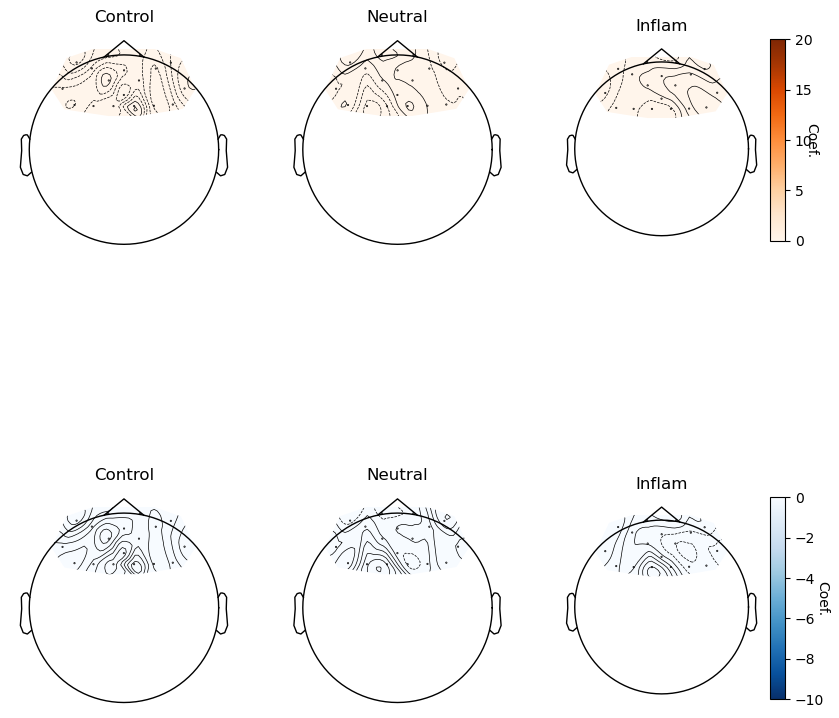

In [266]:
# Group Visualization
importlib.reload(visualizations)

columns_for_glm_contrast = ['Control', 'Neutral', 'Inflam']

channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

Control 3
combining channels using "mean"
Inflam 3
combining channels using "mean"
Neutral 3
combining channels using "mean"
Practice 3
combining channels using "mean"
Control 3
combining channels using "mean"
Inflam 3
combining channels using "mean"
Neutral 3
combining channels using "mean"
Practice 3
combining channels using "mean"


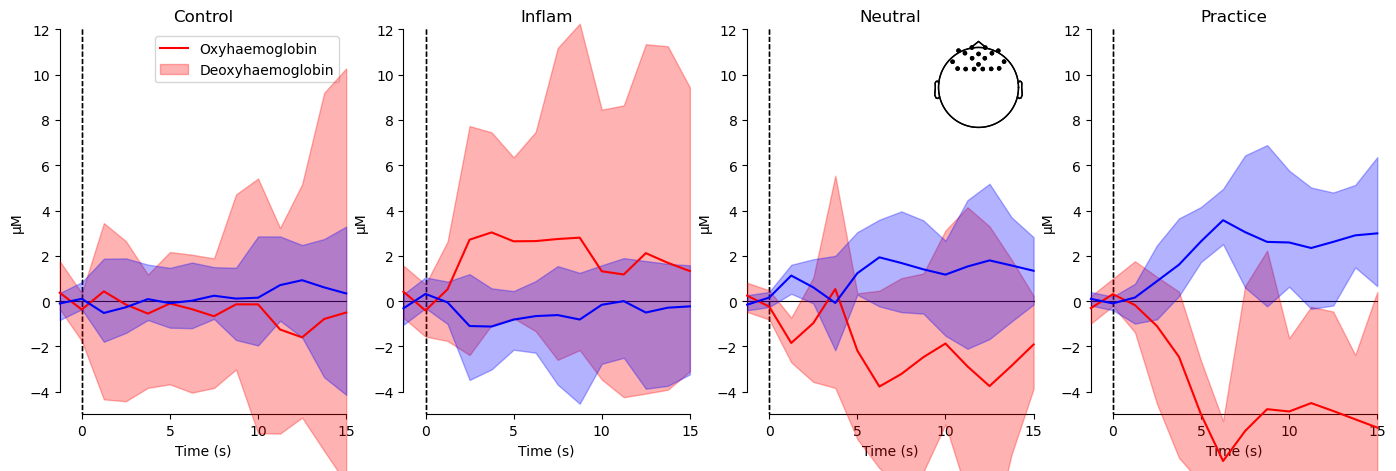

In [255]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

# Statistical Summary

In [256]:
# Generate a summarized dataframe of the channels and conditions significance
importlib.reload(analysis_tools)

ch_model_df = analysis_tools.create_results_dataframe(channels_df, columns_for_glm_contrast, raw_haemo)

ch_model_df['hbr']

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S1_D1 hbr Control    2.051875e-07      0.0  0.444013  6.570334e-01 -0.000001   
          Inflam     6.379554e-07      0.0  1.380495  1.674342e-01      -0.0   
          Neutral   -4.012697e-07      0.0 -0.868322  3.852179e-01 -0.000001   
S1_D2 hbr Control    9.551696e-07      0.0  2.066927  3.874103e-02       0.0   
          Inflam     4.450246e-07      0.0  0.963005  3.355449e-01      -0.0   
          Neutral    2.258259e-06      0.0  4.886730  1.025246e-06  0.000001   
S2_D1 hbr Control    6.399786e-07      0.0  1.384874  1.660911e-01      -0.0   
          Inflam     1.285279e-06      0.0  2.781263  5.414792e-03       0.0   
          Neutral    7.196844e-07      0.0  1.557352  1.193870e-01      -0.0   
S2_D3 hbr Control    2.145845e-06      0.0  4.643474  3.425994e-06  0.000001   
          Inflam     1.287043e-06      0.0  2.785080  5.351450e-03       0.0   
          Neutral   -8.119799e-07      0.0 -1.757073  7.890529e-02 -0.000002   
S3_D3 hbr Control    9.413303e-07      0.0  2.036980  4.165208e-02       0.0   
          Inflam     1.646887e-07      0.0  0.356376  7.215590e-01 -0.000001   
          Neutral    4.855268e-07      0.0  1.050649  2.934196e-01      -0.0   
S3_D4 hbr Control   -9.894573e-08      0.0 -0.214112  8.304595e-01 -0.000001   
          Inflam    -3.560041e-08      0.0 -0.077037  9.385941e-01 -0.000001   
          Neutral    8.141813e-08      0.0  0.176184  8.601496e-01 -0.000001   
S4_D2 hbr Control    1.718515e-06      0.0  3.718759  2.002042e-04  0.000001   
          Inflam     2.028991e-06      0.0  4.390609  1.130334e-05  0.000001   
          Neutral    2.369722e-06      0.0  5.127928  2.929478e-07  0.000001   
S4_D4 hbr Control    1.747385e-06      0.0  3.781231  1.560551e-04  0.000001   
          Inflam     2.288777e-07      0.0  0.495277  6.204047e-01 -0.000001   
          Neutral   -3.070748e-07      0.0 -0.664491  5.063764e-01 -0.000001   
S4_D5 hbr Control   -1.596924e-07      0.0 -0.345564  7.296702e-01 -0.000001   
          Inflam     5.678910e-07      0.0  1.228880  2.191167e-01      -0.0   
          Neutral   -6.738192e-07      0.0 -1.458102  1.448123e-01 -0.000002   
S5_D3 hbr Control    1.110627e-06      0.0  2.403326  1.624670e-02       0.0   
          Inflam     2.408060e-07      0.0  0.521089  6.023047e-01 -0.000001   
          Neutral   -8.131812e-07      0.0 -1.759673  7.846328e-02 -0.000002   
S5_D4 hbr Control    5.724450e-07      0.0  1.238735  2.154437e-01      -0.0   
          Inflam    -4.306745e-07      0.0 -0.931952  3.513611e-01 -0.000001   
          Neutral    3.604827e-08      0.0  0.078006  9.378231e-01 -0.000001   
S5_D6 hbr Control    9.970686e-07      0.0  2.157594  3.095942e-02       0.0   
          Inflam     5.780603e-07      0.0  1.250886  2.109760e-01      -0.0   
          Neutral   -3.215872e-07      0.0 -0.695894  4.864950e-01 -0.000001   
S6_D4 hbr Control    9.481492e-07      0.0  2.051735  4.019541e-02       0.0   
          Inflam    -9.701202e-07      0.0 -2.099279  3.579231e-02 -0.000002   
          Neutral    9.178544e-08      0.0  0.198618  8.425616e-01 -0.000001   
S6_D6 hbr Control    1.306670e-06      0.0  2.827551  4.690547e-03       0.0   
          Inflam    -5.846453e-07      0.0 -1.265136  2.058227e-01 -0.000001   
          Neutral    4.011734e-07      0.0  0.868114  3.853319e-01 -0.000001   
S7_D5 hbr Control    1.293110e-06      0.0  2.798208  5.138696e-03       0.0   
          Inflam    -8.028869e-07      0.0 -1.737397  8.231716e-02 -0.000002   
          Neutral   -1.761610e-07      0.0 -0.381201  7.030538e-01 -0.000001   
S7_D7 hbr Control    1.030910e-06      0.0  2.230824  2.569277e-02       0.0   
          Inflam    -8.126602e-07      0.0 -1.758546  7.865470e-02 -0.000002   
          Neutral    1.109593e-06      0.0  2.401090  1.634633e-02       0.0   
S8_D6 hbr Control    9.59645

KeyError: 'ID'

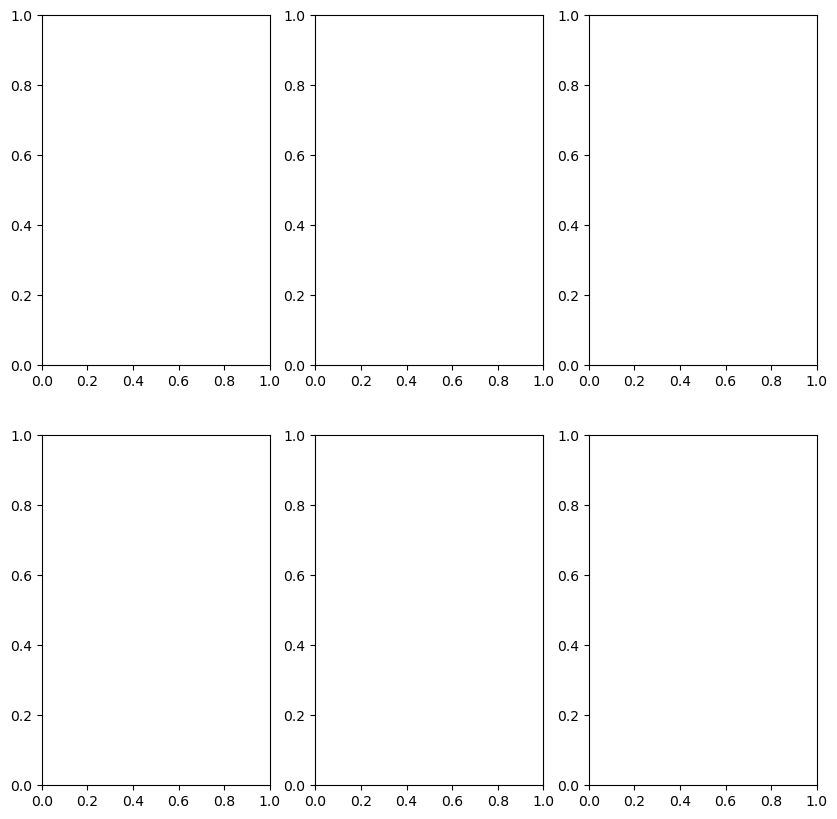

In [257]:
# Individual Visualization
importlib.reload(visualizations)
channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)